## Simulate data and compare to actua ldata

In [2]:
"""
Noor Seijdel, 2019
"""
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import os.path 
import hddm
#import statsmodels.api as sm
from scipy.stats import pearsonr, percentileofscore, ttest_ind, ttest_rel, wilcoxon, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
from patsy import center
%matplotlib inline 
cmap = sns.color_palette("hls", 8)
sns.set_palette(cmap)
sns.set_style("white")
import kabuki

### Experiment 1 

In [3]:
# Load best model (for DIC other models see dic.csv file)
os.chdir('/home/nseijde1/Projects/scenestats/hddmregression/exp1/m9')
model = hddm.load('m9')
print model.dic

-8979.74306032


In [7]:
#load data 
data = hddm.load_csv('/home/nseijde1/Projects/scenestats/hddmregression/exp1_scce.csv') 

In [6]:
import pymc as pm
import numpy as np
import pymc.progressbar as pbar

def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]

def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            sampled_data.reset_index(inplace=True)  # Only modification of original Kabuki code
            sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)
    return datasets

def post_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    results = {}

    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = ((name, model.data.ix[obs['node'].value.index]) for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=['node'])

In [8]:
# now generate + plot posterior predictives
print('sampling posterior predictives')
n_samples = 500
ppc_data = post_pred_gen(model,samples = n_samples, append_data=True, progress_bar=True)
ppc_data.to_csv('posterior_predictive_1.csv')

ppc_compare = hddm.utils.post_pred_stats(data, ppc_data)
print(ppc_compare)
ppc_compare.to_csv('ppc_compare_1.csv')
ppc_stats = hddm.utils.post_pred_stats(data, ppc_data, call_compare=False)


sampling posterior predictives
 [------------------107%-------------------] 41 of 38 complete in 40657.1 sec          observed      mean       std           SEM       MSE credible  \
stat                                                                      
accuracy  0.905783  0.905768  0.058273  2.383946e-10  0.003396     True   
mean_ub   0.462986  0.461157  0.091170  3.347353e-06  0.008315     True   
std_ub    0.139149  0.099394  0.030414  1.580409e-03  0.002505     True   
10q_ub    0.327000  0.359476  0.067880  1.054700e-03  0.005662     True   
30q_ub    0.384000  0.407431  0.075934  5.490176e-04  0.006315     True   
50q_ub    0.437000  0.445565  0.085186  7.335233e-05  0.007330     True   
70q_ub    0.499000  0.490535  0.096140  7.165637e-05  0.009314     True   
90q_ub    0.624000  0.576654  0.125565  2.241608e-03  0.018005     True   
mean_lb  -0.433631 -0.478080  0.132329  1.975705e-03  0.019486     True   
std_lb    0.161067  0.130774  0.056109  9.176650e-04  0.004065     

(-3, 3)

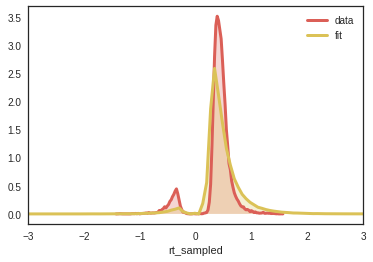

In [160]:
sns.distplot(ppc_data.rt,label='data',hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3}, hist_kws={'edgecolor':'black'})
sns.distplot(ppc_data.rt_sampled,label='fit',hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3}, hist_kws={'edgecolor':'black'})
plt.xlim(-3,3)


### Experiment 2a

In [3]:
# Load best model
os.chdir('/home/nseijde1/Projects/scenestats/hddmregression/exp2a/m6')  
model = hddm.load('m6')

In [4]:
#load data 
data = hddm.load_csv('/home/nseijde1/Projects/scenestats/hddmregression/exp2a_sc.csv') 

In [7]:
# now generate + plot posterior predictives
print('sampling posterior predictives')
n_samples = 500
ppc_data = post_pred_gen(model,samples = n_samples, append_data=True, progress_bar=True)
ppc_data.to_csv('posterior_predictive_2a.csv')

ppc_compare = hddm.utils.post_pred_stats(data, ppc_data)
print(ppc_compare)
ppc_compare.to_csv('ppc_compare_2a.csv')
ppc_stats = hddm.utils.post_pred_stats(data, ppc_data, call_compare=False)


sampling posterior predictives
 [------------------106%------------------] 49 of 46 complete in 41160.6 sec          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.884149  0.882730  0.093873  0.000002  0.008815     True   
mean_ub   0.460673  0.457901  0.076896  0.000008  0.005920     True   
std_ub    0.141426  0.116179  0.033539  0.000637  0.001762     True   
10q_ub    0.323000  0.342089  0.062666  0.000364  0.004292     True   
30q_ub    0.387000  0.397642  0.065712  0.000113  0.004431     True   
50q_ub    0.438000  0.440539  0.069444  0.000006  0.004829     True   
70q_ub    0.498000  0.490581  0.077536  0.000055  0.006066     True   
90q_ub    0.617000  0.587225  0.110065  0.000887  0.013003     True   
mean_lb  -0.411799 -0.458053  0.115921  0.002139  0.015576     True   
std_lb    0.178792  0.139052  0.063120  0.001579  0.005563     True   
10q_lb    0.229000  0.319114  0.077121  0

(-3, 3)

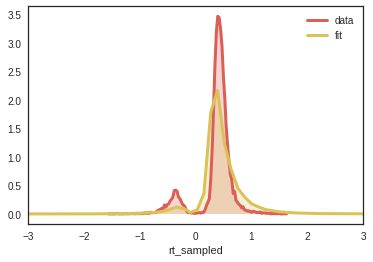

In [8]:
sns.distplot(ppc_data.rt,label='data',hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3}, hist_kws={'edgecolor':'black'})
sns.distplot(ppc_data.rt_sampled,label='fit',hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3}, hist_kws={'edgecolor':'black'})
plt.xlim(-3,3)
